## Introduction

I am looking for a place to open a Colombian restaurant in toronto. In this analysis, I hope to answer what would be the best neighborhoods to make it happen and what do these neighborhoods also have.

## Data

The main data comes from a Foursquare API for Toronto. This data contains neighborhoods as well as venues like restaurants or parks. There is another dataset that contains the coordinates of the neighborhoods so that I can map them in the exploratory data analysis [1]. Another dataset I will use here is the Toronto crime statistics [2], which contains updated information in crime rates over the past five years as well as neighborhood population and area. I think this dataset would be helpful in bringing great insights for this project. Furthermore, the purpose of the analysis process is to consider neighborhood features such as how cultural they are in terms of diverse restaurants, how large communities are, what crime rates say about them.

## Methodology

In [175]:
## Import essential packages
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
import requests
import seaborn as sns

## matplotlib packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
sns.set(style="whitegrid")

### Import Datasets

#### Postal Code/Neighborhood Data

Data Source: https://open.toronto.ca/dataset/neighbourhoods/

In [176]:
toronto = pd.read_csv('Neighbourhoods.csv')
toronto.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,6301,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),NaN,NaN,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
1,6302,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),NaN,NaN,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
2,6303,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),NaN,NaN,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"{u'type': u'Polygon', u'coordinates': (((-79.3..."
3,6304,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),NaN,NaN,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"{u'type': u'Polygon', u'coordinates': (((-79.5..."
4,6305,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),NaN,NaN,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"{u'type': u'Polygon', u'coordinates': (((-79.4..."


In [177]:
toronto.shape

(140, 16)

In [178]:
toronto.columns

Index(['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE',
       'AREA_LONG_CODE', 'AREA_NAME', 'AREA_DESC', 'X', 'Y', 'LONGITUDE',
       'LATITUDE', 'OBJECTID', 'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

In [179]:
## drop unnecessary columns
drop_cols = ['_id','AREA_ID', 'PARENT_AREA_ID', 'AREA_ATTR_ID','AREA_LONG_CODE', 'AREA_DESC', 'X', 'Y', 'OBJECTID', 'geometry']
toronto.drop(columns = drop_cols, inplace= True)

## rename remaining variables for suimplicity
toronto.rename(columns = {'AREA_SHORT_CODE': 'area_code','AREA_NAME':'area_name', 'LONGITUDE':'longitude', 'LATITUDE':'latitude', 'Shape__Area':'shape_area', 'Shape__Length':'shape_length'}, inplace = True)

## remove the numbers in parenthesis from the area names
toronto['area_name'] = toronto.area_name.str.replace('(\(\d\))','')
toronto['area_name'] = toronto.area_name.str.replace('(\(\d\d\))','')
toronto['area_name'] = toronto.area_name.str.replace('(\(\d\d\d\))','')

## The removal of the parentheses left whitespaces at the end of the area names
strips = []
for x in toronto['area_name']:
    strips.append(x.rstrip())

toronto['area_name'] = strips
print(toronto.shape)
toronto.head()

(140, 6)


,area_code,area_name,longitude,latitude,shape_area,shape_length
0,94,Wychwood,-79.425515,43.676919,3.217960e+06,7515.779658
1,100,Yonge-Eglinton,-79.403590,43.704689,3.160334e+06,7872.021074
2,97,Yonge-St.Clair,-79.397871,43.687859,2.222464e+06,8130.411276
3,27,York University Heights,-79.488883,43.765736,2.541821e+07,25632.335242
4,31,Yorkdale-Glen Park,-79.457108,43.714672,1.156669e+07,13953.408098


In [180]:
neighborhood_names = sorted(toronto['area_name'].tolist())
neighborhood_names

['Agincourt North',
 'Agincourt South-Malvern West',
 'Alderwood',
 'Annex',
 'Banbury-Don Mills',
 'Bathurst Manor',
 'Bay Street Corridor',
 'Bayview Village',
 'Bayview Woods-Steeles',
 'Bedford Park-Nortown',
 'Beechborough-Greenbrook',
 'Bendale',
 'Birchcliffe-Cliffside',
 'Black Creek',
 'Blake-Jones',
 'Briar Hill-Belgravia',
 'Bridle Path-Sunnybrook-York Mills',
 'Broadview North',
 'Brookhaven-Amesbury',
 'Cabbagetown-South St.James Town',
 'Caledonia-Fairbank',
 'Casa Loma',
 'Centennial Scarborough',
 'Church-Yonge Corridor',
 'Clairlea-Birchmount',
 'Clanton Park',
 'Cliffcrest',
 'Corso Italia-Davenport',
 'Danforth',
 'Danforth East York',
 'Don Valley Village',
 'Dorset Park',
 'Dovercourt-Wallace Emerson-Junction',
 'Downsview-Roding-CFB',
 'Dufferin Grove',
 'East End-Danforth',
 'Edenbridge-Humber Valley',
 'Eglinton East',
 'Elms-Old Rexdale',
 'Englemount-Lawrence',
 'Eringate-Centennial-West Deane',
 'Etobicoke West Mall',
 'Flemingdon Park',
 'Forest Hill North',

#### Income Data

In [181]:
## import average household income by neighborhood
toronto_inc = pd.read_csv('toronto_income.csv')
toronto_inc

,area,avg_household_income
0,Agincourt North,427037
1,Agincourt South-Malvern West,278390
2,Alderwood,168602
3,Annex,792507
4,Banbury-Don Mills,493486
...,...,...
135,Wychwood,239484
136,Yonge-Eglinton,222648
137,Yonge-St.Clair,541217
138,York University Heights,302358


In [182]:
toronto = toronto.merge(toronto_inc, left_on = 'area_name', right_on = 'area')
toronto.drop(columns = 'area', inplace = True)
toronto

,area_code,area_name,longitude,latitude,shape_area,shape_length,avg_household_income
0,94,Wychwood,-79.425515,43.676919,3.217960e+06,7515.779658,239484
1,100,Yonge-Eglinton,-79.403590,43.704689,3.160334e+06,7872.021074,222648
2,97,Yonge-St.Clair,-79.397871,43.687859,2.222464e+06,8130.411276,541217
3,27,York University Heights,-79.488883,43.765736,2.541821e+07,25632.335242,302358
4,31,Yorkdale-Glen Park,-79.457108,43.714672,1.156669e+07,13953.408098,213860
...,...,...,...,...,...,...,...
135,124,Kennedy Park,-79.260382,43.725556,6.861056e+06,10530.202433,229390
136,78,Kensington-Chinatown,-79.397240,43.653554,2.933586e+06,6945.056557,222404
137,6,Kingsview Village-The Westway,-79.547863,43.698993,9.694496e+06,14458.764271,272950
138,15,Kingsway South,-79.510577,43.653520,5.043477e+06,11140.672714,900624


#### Population/Crime Rate Data

In [283]:
toronto_cr = pd.read_csv('Neighbourhood_Crime_Rates.csv')
toronto_cr

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,...,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length
0,1,Yonge-St.Clair,97,12528,20,29,39,27,34,37,...,5,8,0,3,6,4.3,1.00,47.9,1.161315e+06,5873.270582
1,2,York University Heights,27,27593,271,296,361,344,357,370,...,46,37,39,38,28,36.3,-0.26,101.5,1.324666e+07,18504.777326
2,3,Lansing-Westgate,38,16164,44,80,68,85,75,72,...,5,5,11,6,11,7.0,0.83,68.1,5.346186e+06,11112.109625
3,4,Yorkdale-Glen Park,31,14804,106,136,174,161,175,209,...,14,26,23,20,29,22.5,0.45,195.9,6.038326e+06,10079.426920
4,5,Stonegate-Queensway,16,25051,88,71,76,95,87,82,...,8,4,6,7,4,6.0,-0.43,16.0,7.946202e+06,11853.189878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,136,Milliken,130,26572,66,92,88,80,78,99,...,14,10,19,18,22,16.5,0.22,82.8,9.477859e+06,16781.477343
136,137,Pleasant View,46,15818,34,50,58,53,37,44,...,5,3,4,5,4,3.8,-0.20,25.3,2.967493e+06,7944.829848
137,138,Wychwood,94,14349,54,76,86,55,76,74,...,1,4,4,2,0,2.3,-1.00,0.0,1.682111e+06,5435.021879
138,139,Leaside-Bennington,56,16828,38,27,33,35,33,31,...,5,2,4,4,7,5.2,0.75,41.6,4.784766e+06,14836.618578


In [184]:
toronto_cr.columns

Index(['OBJECTID', 'Neighbourhood', 'Hood_ID', 'Population', 'Assault_2014',
       'Assault_2015', 'Assault_2016', 'Assault_2017', 'Assault_2018',
       'Assault_2019', 'Assault_AVG', 'Assault_CHG', 'Assault_Rate_2019',
       'AutoTheft_2014', 'AutoTheft_2015', 'AutoTheft_2016', 'AutoTheft_2017',
       'AutoTheft_2018', 'AutoTheft_2019', 'AutoTheft_AVG', 'AutoTheft_CHG',
       'AutoTheft_Rate_2019', 'BreakandEnter_2014', 'BreakandEnter_2015',
       'BreakandEnter_2016', 'BreakandEnter_2017', 'BreakandEnter_2018',
       'BreakandEnter_2019', 'BreakandEnter_AVG', 'BreakandEnter_CHG',
       'BreakandEnter_Rate_2019', 'Homicide_2014', 'Homicide_2015',
       'Homicide_2016', 'Homicide_2017', 'Homicide_2018', 'Homicide_2019',
       'Homicide_AVG', 'Homicide_CHG', 'Homicide_Rate_2019', 'Robbery_2014',
       'Robbery_2015', 'Robbery_2016', 'Robbery_2017', 'Robbery_2018',
       'Robbery_2019', 'Robbery_AVG', 'Robbery_CHG', 'Robbery_Rate_2019',
       'TheftOver_2014', 'TheftOver_201

In [185]:
## create overall rates for every year

def create_overall_rate(df, year):

    # columns to retain - ending in "Rate_year"
    rates_year = [col for col in df.columns if ('_Rate_' + str(year)) in col]


    ## create combined crime rate in for a given year and exclude columns from the ret_cols list
    cols_year = [col for col in df.columns if ('_' + str(year)) in col not in rates_year] 
    
    ## print list of variables used to calculate the combined crime rate by year
    print(cols_year)
    
    overall_rate = (df.loc[:,cols_year].sum(axis = 1)/ df['Population']) * 1000
    
    return overall_rate

In [186]:
## add the combined crime rates from 2017 to 2019

toronto_cr['crime_rate_17'] = create_overall_rate(toronto_cr, 2017)
toronto_cr['crime_rate_18'] = create_overall_rate(toronto_cr, 2018)
toronto_cr['crime_rate_19'] = create_overall_rate(toronto_cr, 2019)
toronto_cr.head()

['Assault_2017', 'AutoTheft_2017', 'BreakandEnter_2017', 'Homicide_2017', 'Robbery_2017', 'TheftOver_2017']
['Assault_2018', 'AutoTheft_2018', 'BreakandEnter_2018', 'Homicide_2018', 'Robbery_2018', 'TheftOver_2018']
['Assault_2019', 'AutoTheft_2019', 'BreakandEnter_2019', 'Homicide_2019', 'Robbery_2019', 'TheftOver_2019']


,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,...,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length,crime_rate_17,crime_rate_18,crime_rate_19
0,1,Yonge-St.Clair,97,12528,20,29,39,27,34,37,...,3,6,4.3,1.00,47.9,1.161315e+06,5873.270582,4.469987,5.747126,6.465517
1,2,York University Heights,27,27593,271,296,361,344,357,370,...,38,28,36.3,-0.26,101.5,1.324666e+07,18504.777326,23.774146,25.296271,26.419744
2,3,Lansing-Westgate,38,16164,44,80,68,85,75,72,...,6,11,7.0,0.83,68.1,5.346186e+06,11112.109625,11.197723,11.878248,10.207869
3,4,Yorkdale-Glen Park,31,14804,106,136,174,161,175,209,...,20,29,22.5,0.45,195.9,6.038326e+06,10079.426920,22.291273,24.858146,28.776006
4,5,Stonegate-Queensway,16,25051,88,71,76,95,87,82,...,7,4,6.0,-0.43,16.0,7.946202e+06,11853.189878,8.303062,7.544609,8.223225


In [187]:
## remove all crime statistics columns except for crime rates in 2019

# drop columns with individual records by year and spare the 2019 rates
drop_cols = [col for col in toronto_cr.columns if '_20' in col]


## remove record ending in "CHG" or "AVG"
drop_cols += [col for col in toronto_cr.columns if '_CHG' in col]
drop_cols += [col for col in toronto_cr.columns if '_AVG' in col]

## also remove the following
drop_cols += ['OBJECTID', 'Shape__Area', 'Shape__Length']

toronto_cr.drop(columns= drop_cols, inplace= True)
toronto_cr

,Neighbourhood,Hood_ID,Population,crime_rate_17,crime_rate_18,crime_rate_19
0,Yonge-St.Clair,97,12528,4.469987,5.747126,6.465517
1,York University Heights,27,27593,23.774146,25.296271,26.419744
2,Lansing-Westgate,38,16164,11.197723,11.878248,10.207869
3,Yorkdale-Glen Park,31,14804,22.291273,24.858146,28.776006
4,Stonegate-Queensway,16,25051,8.303062,7.544609,8.223225
...,...,...,...,...,...,...
135,Milliken,130,26572,11.290080,12.193286,13.924432
136,Pleasant View,46,15818,5.752940,5.942597,6.258693
137,Wychwood,94,14349,8.711408,10.523381,9.617395
138,Leaside-Bennington,56,16828,4.575707,7.190397,6.893273


In [188]:
toronto = toronto.merge(toronto_cr, left_on = 'area_code', right_on = 'Hood_ID')
toronto.drop(columns = ['Neighbourhood', 'Hood_ID'], inplace = True)
toronto.rename(columns = {'area_name':'neighborhood', 'Population':'population'}, inplace = True)
toronto

,area_code,neighborhood,longitude,latitude,shape_area,shape_length,avg_household_income,population,crime_rate_17,crime_rate_18,crime_rate_19
0,94,Wychwood,-79.425515,43.676919,3.217960e+06,7515.779658,239484,14349,8.711408,10.523381,9.617395
1,100,Yonge-Eglinton,-79.403590,43.704689,3.160334e+06,7872.021074,222648,11817,9.647119,13.116696,15.655412
2,97,Yonge-St.Clair,-79.397871,43.687859,2.222464e+06,8130.411276,541217,12528,4.469987,5.747126,6.465517
3,27,York University Heights,-79.488883,43.765736,2.541821e+07,25632.335242,302358,27593,23.774146,25.296271,26.419744
4,31,Yorkdale-Glen Park,-79.457108,43.714672,1.156669e+07,13953.408098,213860,14804,22.291273,24.858146,28.776006
...,...,...,...,...,...,...,...,...,...,...,...
135,124,Kennedy Park,-79.260382,43.725556,6.861056e+06,10530.202433,229390,17123,19.272324,20.206739,18.863517
136,78,Kensington-Chinatown,-79.397240,43.653554,2.933586e+06,6945.056557,222404,17945,36.611870,43.800502,43.076066
137,6,Kingsview Village-The Westway,-79.547863,43.698993,9.694496e+06,14458.764271,272950,22000,9.090909,9.636364,7.863636
138,15,Kingsway South,-79.510577,43.653520,5.043477e+06,11140.672714,900624,9271,9.599827,8.197605,10.462733


### Exploratory Data Analysis

#### Correlations

In [189]:
toronto.columns

Index(['area_code', 'neighborhood', 'longitude', 'latitude', 'shape_area',
       'shape_length', 'avg_household_income', 'population', 'crime_rate_17',
       'crime_rate_18', 'crime_rate_19'],
      dtype='object')

In [190]:
X = toronto.loc[:,['shape_area', 'shape_length', 'avg_household_income', 'population', 'crime_rate_17', 'crime_rate_18',
       'crime_rate_19']]
toronto_corr = X.corr()
toronto_corr

,shape_area,shape_length,avg_household_income,population,crime_rate_17,crime_rate_18,crime_rate_19
shape_area,1.000000,0.833468,0.360923,0.594386,0.082790,0.082799,0.036016
shape_length,0.833468,1.000000,0.390704,0.540400,0.063015,0.052538,0.006830
avg_household_income,0.360923,0.390704,1.000000,0.415123,-0.105774,-0.125585,-0.105567
population,0.594386,0.540400,0.415123,1.000000,0.141096,0.128493,0.107520
crime_rate_17,0.082790,0.063015,-0.105774,0.141096,1.000000,0.969557,0.959072
crime_rate_18,0.082799,0.052538,-0.125585,0.128493,0.969557,1.000000,0.968150
crime_rate_19,0.036016,0.006830,-0.105567,0.107520,0.959072,0.968150,1.000000


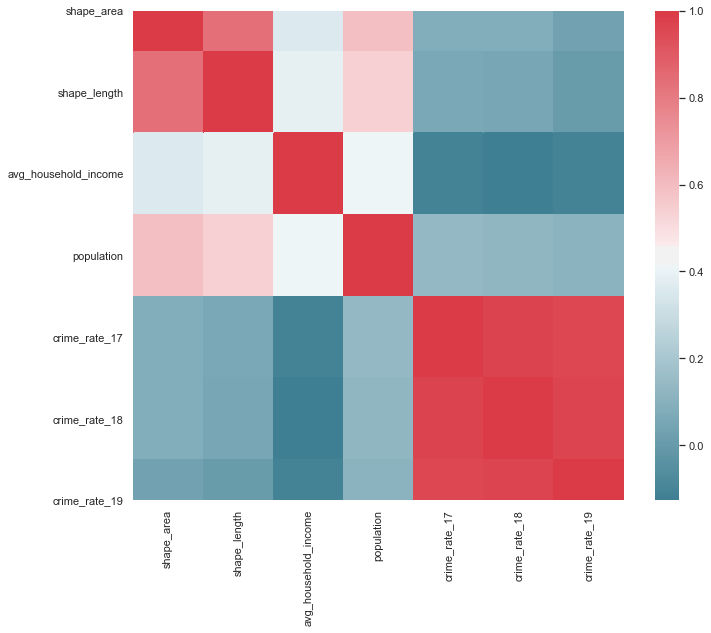

In [191]:
plt.figure(figsize = (11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(toronto_corr, cmap = cmap);

- The correlation between neighborhood shape length and area are highly correlated as well as all of the combined crime rates. 
- The three annual crime rates have high degrees of correlation with each other, let's take a look at their variabce inflation factor values.

In [192]:
## calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif

,VIF,features
0,5.900379,shape_area
1,11.755830,shape_length
2,4.182230,avg_household_income
3,7.473740,population
4,83.820920,crime_rate_17
5,101.617077,crime_rate_18
6,76.704289,crime_rate_19


- Values considered too high are above 10, thererefure shape length should be the first value to be dropped.
- Due to the high correlation between the annual crime rates, it is best to focus on the most recent year. Therefore, we keep the 2019 crime rate instead of using the crime rates from the past three years.

In [193]:
## recalculate correlation with the reduced variables
X = toronto.loc[:,['shape_area', 'avg_household_income', 'population',
       'crime_rate_19']]
toronto_corr = X.corr()
toronto_corr

,shape_area,avg_household_income,population,crime_rate_19
shape_area,1.000000,0.360923,0.594386,0.036016
avg_household_income,0.360923,1.000000,0.415123,-0.105567
population,0.594386,0.415123,1.000000,0.107520
crime_rate_19,0.036016,-0.105567,0.107520,1.000000


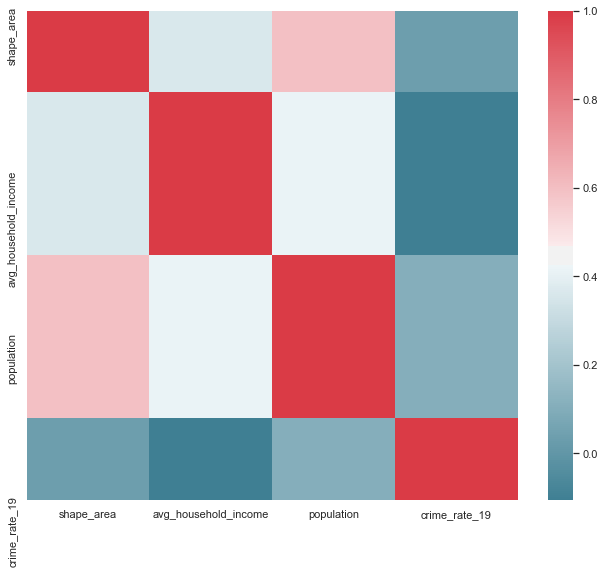

In [194]:
plt.figure(figsize = (11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(toronto_corr, cmap = cmap);

In [195]:
## Second VIF table
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif

,VIF,features
0,3.086059,shape_area
1,3.631153,avg_household_income
2,6.896971,population
3,2.758644,crime_rate_19


- The correlation between neighborhood shape length and area are highly correlated. Therefore, since neighborhood area seems more important than shape length, then the latter should be dropped from the dataset.
- Also, individual crime rates such as robbery, theft, and assault have high degrees of correlation with to other variables. Hence, in order to work with crime rate, it would be best to keep the overall rate since all individual crime rates were used to calculate this variable.
- Although the correaltion between area and population is almost 0.6, it does not qualify as multicollinearity so I will keep both of these variables.

(array([48., 50., 25.,  8.,  2.,  3.,  0.,  1.,  1.,  2.]),
 array([ 5.04184733,  9.85223406, 14.66262079, 19.47300752, 24.28339425,
        29.09378098, 33.9041677 , 38.71455443, 43.52494116, 48.33532789,
        53.14571462]),
 <a list of 10 Patch objects>)

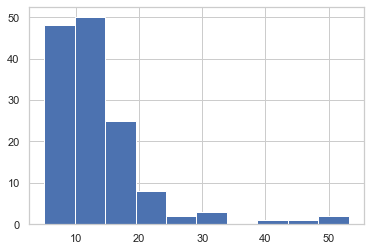

In [196]:
plt.hist(toronto.crime_rate_19)

In [197]:
toronto.drop(columns= ['shape_length', 'crime_rate_17', 'crime_rate_18'], inplace= True)
toronto

,area_code,neighborhood,longitude,latitude,shape_area,avg_household_income,population,crime_rate_19
0,94,Wychwood,-79.425515,43.676919,3.217960e+06,239484,14349,9.617395
1,100,Yonge-Eglinton,-79.403590,43.704689,3.160334e+06,222648,11817,15.655412
2,97,Yonge-St.Clair,-79.397871,43.687859,2.222464e+06,541217,12528,6.465517
3,27,York University Heights,-79.488883,43.765736,2.541821e+07,302358,27593,26.419744
4,31,Yorkdale-Glen Park,-79.457108,43.714672,1.156669e+07,213860,14804,28.776006
...,...,...,...,...,...,...,...,...
135,124,Kennedy Park,-79.260382,43.725556,6.861056e+06,229390,17123,18.863517
136,78,Kensington-Chinatown,-79.397240,43.653554,2.933586e+06,222404,17945,43.076066
137,6,Kingsview Village-The Westway,-79.547863,43.698993,9.694496e+06,272950,22000,7.863636
138,15,Kingsway South,-79.510577,43.653520,5.043477e+06,900624,9271,10.462733


#### Map of Neighborhoods

In [198]:
## plot folium of torotnto postal codes
latitude = 43.6532
longitude = -79.3832
map_toronto = folium.Map(location=[latitude, longitude], zoom_start= 11)

for lat, lon, pcode in zip(toronto['latitude'], toronto['longitude'], toronto['neighborhood']): 
    folium.CircleMarker(
    [lat, lon],
    popup= pcode,
    radius = 3,
    color = 'blue',
    fill = True).add_to(map_toronto)
map_toronto

#### Neighborhoods by population

In [324]:
## function that returns most and least neigborhoods by variable as well as 
## a respective map of neighborhoods

def basic_graphs(col, bubble_size, bubble_col1, bubble_col2, var_name):
    latitude = 43.6532
    longitude = -79.3832
      
    ## sort neighborhoods by population in desceniding order
    toronto.sort_values(by = col, ascending = False, inplace = True)
    toronto_top10 = toronto.iloc[:10,:]

    
    plt.figure(figsize= (14, 8))
    ## plot the 10 most populated neighborhoods
    sns.barplot(y = 'neighborhood', x = col, data = toronto_top10) 
    plt.title('Top 10 Toronto Neighborhoods by ' + var_name)
    plt.ylabel('Neighborhood')
    plt.xlabel(var_name)
    plt.show()
    
    ## sort neighborhoods by population in ascending order
    toronto.sort_values(by = col, inplace = True)
    toronto_bot10 = toronto.iloc[:10,:]

    plt.figure(figsize= (14, 8))
    ## plot the 10 most populated neighborhoods
    sns.barplot(y = 'neighborhood', x = col, data = toronto_bot10) 
    plt.title('Bottom 10 Toronto Neighborhoods by ' + var_name)
    plt.ylabel('Neighborhood')
    plt.xlabel(var_name)
    plt.show()
    
    ## plot the above neighborhoods in a map
    
    map_toronto = folium.Map(location=[latitude, longitude], zoom_start= 11)
    
    ## for top 10
    for lat, lon, area, var in zip(toronto_top10.loc[:,'latitude'], toronto_top10.loc[:,'longitude'], toronto_top10.loc[:,'neighborhood'], toronto_top10.loc[:,col]): 
        folium.CircleMarker(
        [lat, lon],
        popup= area + " " + str(round(var)),
        radius = var * bubble_size,
        color = bubble_col1,
        fill = True).add_to(map_toronto)
        
    ## for bottom 10  
    for lat, lon, area, var in zip(toronto_bot10.loc[:,'latitude'], toronto_bot10.loc[:,'longitude'], toronto_bot10.loc[:,'neighborhood'], toronto_bot10.loc[:,col]): 
        folium.CircleMarker(
        [lat, lon],
        popup= area + " " + str(round(var)),
        radius = var * bubble_size,
        color = bubble_col2,
        fill = True).add_to(map_toronto)
    
    return map_toronto
    

#### Neighborhoods by population

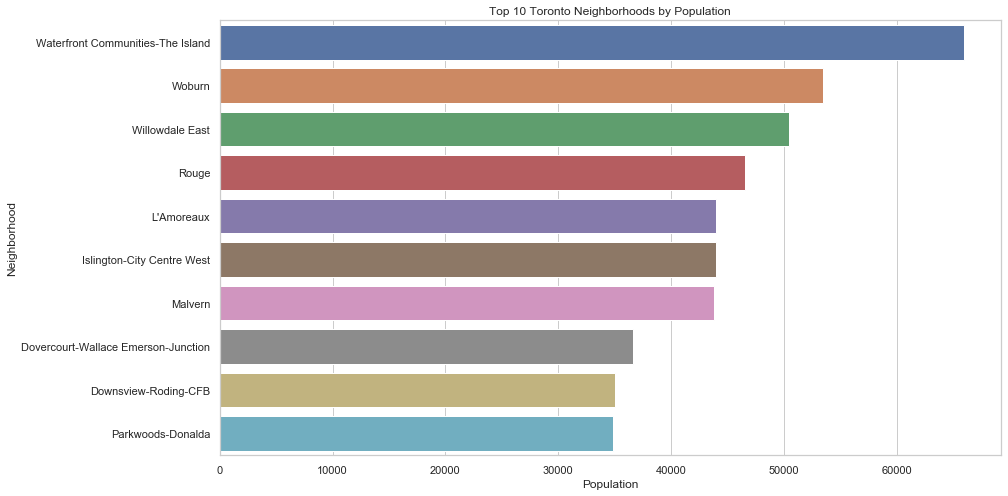

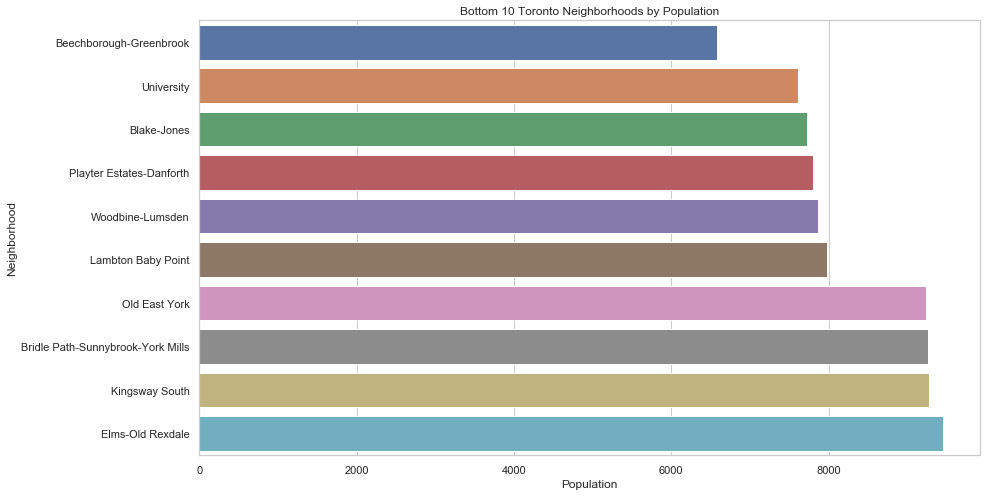

In [325]:
basic_graphs('population', 0.0005, 'crimson', 'green', 'Population')

- Since the size of the bubbles tell us which neighborhoods are the most populated with a popup, let's also plot the ten most and least populated neighborhoods as a summary of the map above.

#### Neighborhoods by Income

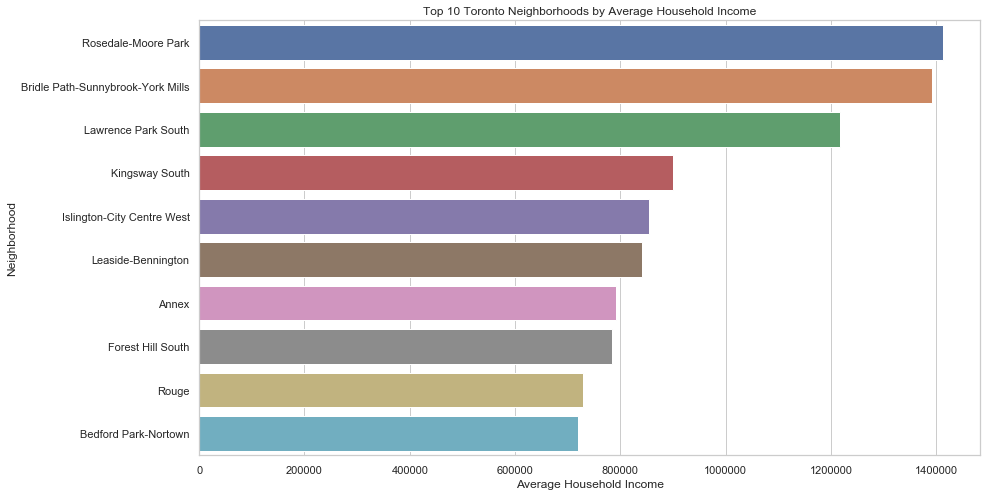

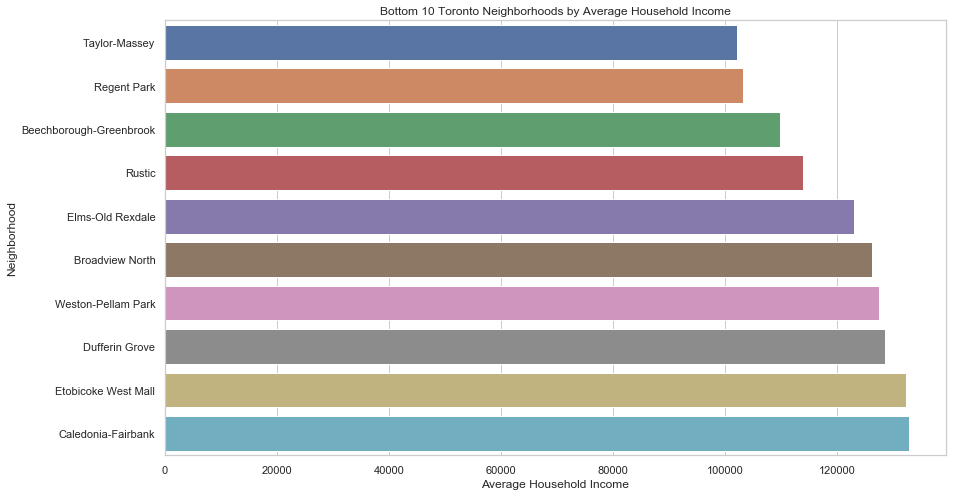

In [326]:
basic_graphs('avg_household_income', 0.000019, 'crimson', 'green', 'Average Household Income')

#### Neighborhoods by crime rates

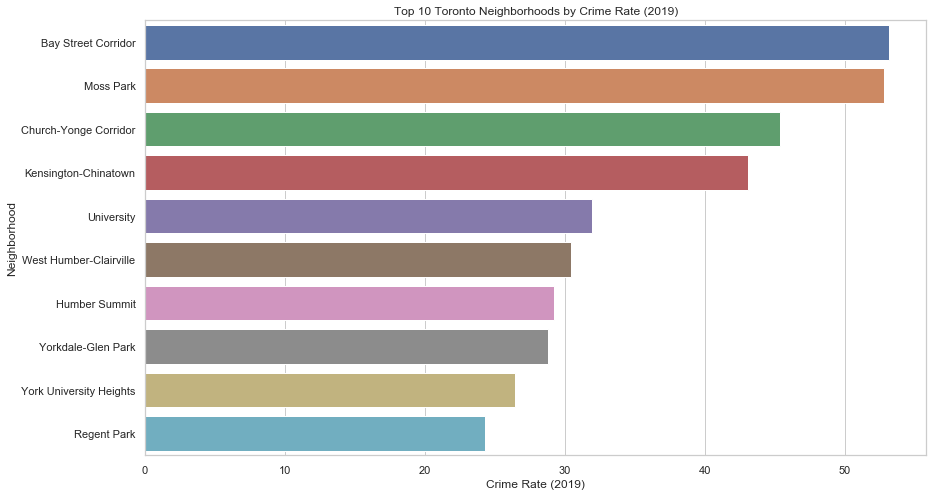

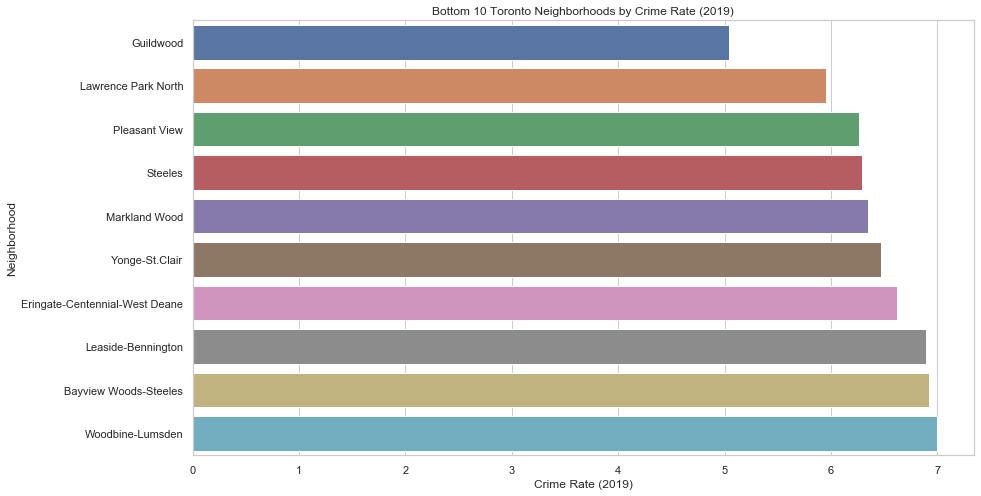

In [328]:
basic_graphs('crime_rate_19', 0.5, 'crimson', 'steelblue','Crime Rate (2019)')


- According to the plots above, Bay Street Corridor has the highest crime rate in the data, while Guildwood has the lowest. 
- Moss Park has almost the same rate as Bay Street Corridor while Lawrence Park North differs from Guildwood by 100 incidents per 10000 people.

- It looks like the downtown area has a cluster of high crime rates, even though four other neighborhoods are more spread out in the northwest.
- Both Bay Street Corridor and Moss Park are close to each other located in the downtown area.
- Guildwood and Lawrence Park North are far from each other and from downtown.

## Using the API to Gather Venue Data by Postal Code

In [164]:
CLIENT_ID = 'UZ0FU4P3QJ2IJ3AV32SZWYQEXNVPYZQD0SQ0SOGGXTLEGSVX' # your Foursquare ID
CLIENT_SECRET = 'JWAPKYK0JUIZK3YI0503MNWLSHE5AWKU3S4DHMB2OU4VTKIR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentials:
CLIENT_ID: UZ0FU4P3QJ2IJ3AV32SZWYQEXNVPYZQD0SQ0SOGGXTLEGSVX
CLIENT_SECRET:JWAPKYK0JUIZK3YI0503MNWLSHE5AWKU3S4DHMB2OU4VTKIR


In [165]:
toronto.head()

,area_code,neighborhood,longitude,latitude,shape_area,shape_length,avg_household_income,population,crime_rate_17,crime_rate_18,crime_rate_19
121,140,Guildwood,-79.195055,43.748829,7.294790e+06,13609.015920,177062,9917,705.858627,685.691237,504.184733
7,105,Lawrence Park North,-79.403978,43.730060,4.388577e+06,9051.488042,470908,14607,684.603272,527.144520,595.604847
37,46,Pleasant View,-79.334948,43.786982,5.697613e+06,11016.711770,219209,15818,575.293969,594.259704,625.869263
51,116,Steeles,-79.321207,43.812959,8.765411e+06,12392.942855,363045,24623,511.716688,519.839175,629.492751
14,12,Markland Wood,-79.573432,43.633542,5.643281e+06,10845.612363,195412,10554,530.604510,710.631040,634.830396


In [166]:
## explore a neighborhood: Yonge-Eglinton
print(toronto.loc[1, 'neighborhood'])
neighborhood_latitude = toronto.loc[1, 'latitude'] # neighborhood latitude value
neighborhood_longitude = toronto.loc[1, 'longitude'] # neighborhood longitude value

neighborhood_name = toronto.loc[1, 'neighborhood'] # neighborhood name

radius = 1000
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, neighborhood_latitude, neighborhood_longitude, radius, LIMIT)
results = requests.get(url).json()
results

Yonge-Eglinton


{'meta': {'code': 200, 'requestId': '5f44952bcd347610a78187f0'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 115,
  'suggestedBounds': {'ne': {'lat': 43.71368937670002,
    'lng': -79.39116372780647},
   'sw': {'lat': 43.695689358699994, 'lng': -79.41601660719353}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4bc217f964a520a8a626e3',
       'name': 'North Toronto Memorial Community Centre',
       'location': {'address': '200 eglinton ave west',
        'crossStreet': 'Oriole parkway',
        'lat': 43.706097953892986,
        'lng': -79.40433712056412,
        'labeledL

In [167]:
## define get_gategory type
from pandas.io.json import json_normalize

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## structure venues from this postal code in a dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,North Toronto Memorial Community Centre,Gym,43.706098,-79.404337
1,Eglinton Park,Park,43.707430,-79.405359
2,Burger Shack,Burger Joint,43.704855,-79.406067
3,Yonge Eglinton Square,Plaza,43.706864,-79.398751
4,Boom Breakfast & Co.,Breakfast Spot,43.705748,-79.403482


In [233]:
## create a function that will repeat the same process to 
## all postal codes in Toronto

def getNearbyPlaces(names, lats, longs, radius = 1000):
    place_list = []
    for name, lat, lon in zip(names, lats, longs):
        
        ## access API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, radius, LIMIT)
        
        ## request
        res = requests.get(url).json()['response']['groups'][0]['items']

        
        ## return relevant information for each place
        place_list.append([(name, lat, lon, 
                            v['venue']['name'],
                           v['venue']['location']['lat'],
                           v['venue']['location']['lng'],
                           v['venue']['categories'][0]['name']) for v in res])
        nearby_venues = pd.DataFrame([item for place in place_list for item in place])
        nearby_venues.columns = ['neighborhood', 
                  'neighborhood_latitude', 
                  'neighborhood_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    return(nearby_venues)

In [234]:
toronto_venues = getNearbyPlaces(names=toronto['neighborhood'],
                                   lats=toronto['latitude'],
                                   longs=toronto['longitude']
                                  )

In [235]:
print(toronto_venues.shape)
toronto_venues.head()

(5684, 7)


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Guildwood,43.748829,-79.195055,Guildwood Park,43.747856,-79.191899,Park
1,Guildwood,43.748829,-79.195055,Tim Hortons,43.746559,-79.200257,Coffee Shop
2,Guildwood,43.748829,-79.195055,Valumart,43.746874,-79.201001,Grocery Store
3,Guildwood,43.748829,-79.195055,The Guild Inn,43.748229,-79.192334,Hotel
4,Guildwood,43.748829,-79.195055,Subway,43.747099,-79.199549,Sandwich Place


In [236]:
## write venue data to CSV
toronto_venues.to_csv('toronto_venues.csv', index = False)

In [207]:
toronto_venues = pd.read_csv('toronto_venues.csv')
toronto_venues.head()

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Guildwood,43.748829,-79.195055,Guildwood Park,43.747856,-79.191899,Park
1,Guildwood,43.748829,-79.195055,Tim Hortons,43.746559,-79.200257,Coffee Shop
2,Guildwood,43.748829,-79.195055,Valumart,43.746874,-79.201001,Grocery Store
3,Guildwood,43.748829,-79.195055,The Guild Inn,43.748229,-79.192334,Hotel
4,Guildwood,43.748829,-79.195055,Subway,43.747099,-79.199549,Sandwich Place


In [208]:
## remove one duplicate that appeared in ther original data
toronto_venues.drop_duplicates(inplace= True)

In [209]:
toronto_venues.shape

(5683, 7)

#### Explore Venue Data

In [210]:
## how many venue categories?
len(toronto_venues['venue_category'].unique())

351

In [211]:
## Plot Heatmap
from folium.plugins import HeatMap

map_toronto = folium.Map(location=[latitude, longitude], zoom_start= 11)

toronto_heat = toronto_venues[['neighborhood_latitude', 'neighborhood_longitude']]

HeatMap(data = toronto_heat, radius = 20).add_to(map_toronto)

map_toronto

- According to the map, the venues present in the data are more clustered in the downtown areas and become more spread out as they are farther from said zone.

#### Plot Neighborhoods by Number of Venues

In [212]:
## Arrange neighborhoods by number of venues
num_venues = toronto_venues['neighborhood'].value_counts()
#num_venues.sort_values(by = 'venue', ascending = False, inplace = True)
num_venues = pd.DataFrame(num_venues)
num_venues

,neighborhood
Niagara,100
Moss Park,100
North St.James Town,100
Mount Pleasant East,100
Dovercourt-Wallace Emerson-Junction,100
...,...
Centennial Scarborough,5
Princess-Rosethorn,4
Willowdale West,4
Newtonbrook West,4


In [213]:
## extract the top 15 neighborhoods
num_venues_top = num_venues.iloc[:15,]
num_venues_top

,neighborhood
Niagara,100
Moss Park,100
North St.James Town,100
Mount Pleasant East,100
Dovercourt-Wallace Emerson-Junction,100
Regent Park,100
Annex,100
Bay Street Corridor,100
Playter Estates-Danforth,100
University,100


In [214]:
## get coordinates from the abobe neighborhoods and map them
nb_top = toronto[toronto['neighborhood'].isin(num_venues_top.index)]
nb_top.head()

,area_code,neighborhood,longitude,latitude,shape_area,avg_household_income,population,crime_rate_19
21,99,Mount Pleasant East,-79.384924,43.704852,5.914750e+06,348357,16775,7.630402
10,84,Little Portugal,-79.430323,43.647536,2.324743e+06,202912,15559,11.440324
88,69,Blake-Jones,-79.337394,43.676173,1.800512e+06,154132,7727,14.106380
27,68,North Riverdale,-79.351260,43.671995,3.416312e+06,318764,11916,14.182612
106,93,Dovercourt-Wallace Emerson-Junction,-79.438541,43.665677,7.125378e+06,594477,36625,15.044369


In [215]:
## Where are these neighborhoods located?

map_toronto = folium.Map(location=[latitude, longitude], zoom_start= 12)

for lat, lon, pcode in zip(nb_top['latitude'], nb_top['longitude'], nb_top['neighborhood']): 
    folium.CircleMarker(
    [lat, lon],
    popup= pcode,
    radius = 4,
    color = 'black',
    fill = True).add_to(map_toronto)

map_toronto


- Not surprisingly, the postal codes with the most venues are located close to each other in the downtown Toronto area.
- It might seem like number of venues and crime rate are correlated in some way.

In [216]:
venue_counts = toronto_venues['venue_category'].value_counts()
venue_counts = pd.DataFrame({'num_categories':venue_counts})
venue_counts.head(20)

,num_categories
Coffee Shop,398
Park,228
Café,226
Pizza Place,193
Bakery,143
Sandwich Place,135
Grocery Store,129
Restaurant,127
Italian Restaurant,127
Bank,110


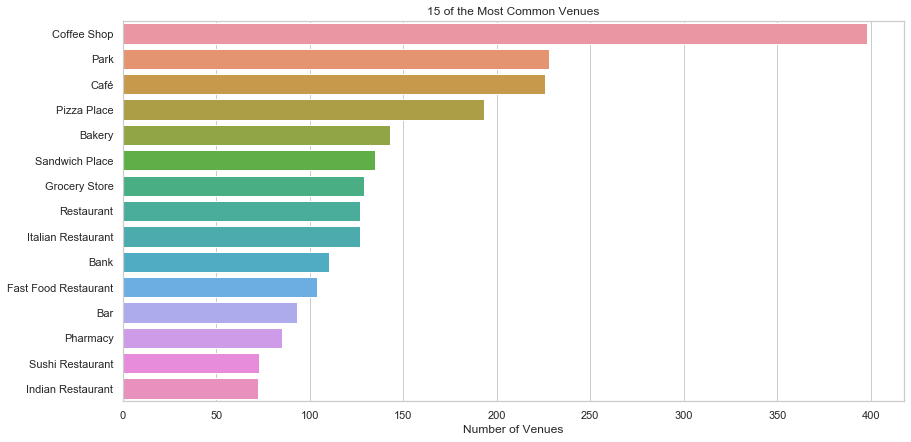

In [217]:
top_venues = venue_counts.iloc[:15,:]
plt.figure(figsize= (14, 7))
sns.barplot(y = top_venues.index, x = 'num_categories', data = top_venues)
plt.title('15 of the Most Common Venues')
plt.xlabel('Number of Venues');

In [218]:
venue_counts.iloc[:15,:]

,num_categories
Coffee Shop,398
Park,228
Café,226
Pizza Place,193
Bakery,143
Sandwich Place,135
Grocery Store,129
Restaurant,127
Italian Restaurant,127
Bank,110


## Neighborhood Analysis
In this section I am going to analyze each neighborhood to get their most common venue types before clustering the data.

In [219]:
## get dummies for venue data
toronto_dum = pd.get_dummies(toronto_venues[['venue_category']], prefix= "", prefix_sep = "")

## add neighborhood
toronto_dum['neighborhood'] = toronto_venues['neighborhood']

## move neighborhood to the first column
new_cols = [toronto_dum.columns[-1]] + list(toronto_dum.columns[:-1])
toronto_dum = toronto_dum[new_cols]
toronto_dum.head()

,neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Guildwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Guildwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Guildwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Guildwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Guildwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [220]:
print("The venue data has",toronto_dum.shape[0], "observations and", toronto_dum.shape[1], "columns")

The venue data has 5683 observations and 352 columns


In [221]:
## group rows by neighborhood by number of venue categories
toronto_grouped = toronto_dum.groupby('neighborhood').mean().reset_index()
toronto_grouped

,neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt North,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.047619,0.0,0.0,0.000000,0.0,0.02381,0.000000,0.000000,0.0,0.0
1,Agincourt South-Malvern West,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0
2,Alderwood,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0
3,Annex,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.010000,0.0,0.0
4,Banbury-Don Mills,0.0,0.000000,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.042553,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Wychwood,0.0,0.000000,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.010417,0.0,0.0
136,Yonge-Eglinton,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.010000,0.0,0.0,0.010000,0.0,0.00000,0.000000,0.010000,0.0,0.0
137,Yonge-St.Clair,0.0,0.000000,0.0,0.0,0.0,0.012821,0.0,0.0,0.0,...,0.012821,0.0,0.0,0.012821,0.0,0.00000,0.000000,0.012821,0.0,0.0
138,York University Heights,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0


In [222]:
## merge with crime statistics
toronto_grouped2 = toronto_grouped.merge(toronto, left_on = 'neighborhood', right_on = 'neighborhood')
toronto_grouped2.drop(columns = 'area_code', inplace = True)
toronto_grouped2

,neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,longitude,latitude,shape_area,avg_household_income,population,crime_rate_19
0,Agincourt North,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,-79.266712,43.805441,1.395145e+07,427037,29113,7.350668
1,Agincourt South-Malvern West,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,-79.265612,43.788658,1.511736e+07,278390,23757,13.848550
2,Alderwood,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,-79.541611,43.604937,9.502180e+06,168602,12054,7.300481
3,Annex,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.010000,0.0,0.0,-79.404001,43.671585,5.337192e+06,792507,30526,19.786412
4,Banbury-Don Mills,0.0,0.000000,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,...,0.042553,0.000000,0.0,0.0,-79.349718,43.737657,1.924897e+07,493486,27695,7.979780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Wychwood,0.0,0.000000,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,...,0.000000,0.010417,0.0,0.0,-79.425515,43.676919,3.217960e+06,239484,14349,9.617395
136,Yonge-Eglinton,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.010000,0.0,0.0,-79.403590,43.704689,3.160334e+06,222648,11817,15.655412
137,Yonge-St.Clair,0.0,0.000000,0.0,0.0,0.0,0.012821,0.0,0.0,0.0,...,0.000000,0.012821,0.0,0.0,-79.397871,43.687859,2.222464e+06,541217,12528,6.465517
138,York University Heights,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,-79.488883,43.765736,2.541821e+07,302358,27593,26.419744


### Standardize Data

Before performing principal component analysis, the data must be standardized due to varying ranges in variables

In [223]:
## standardized data in order to perform unsupervised analysis
from sklearn.preprocessing import StandardScaler

toronto_tosc = toronto[['shape_area', 'avg_household_income', 'population', 'crime_rate_19']]

sc = StandardScaler()
toronto_sc = sc.fit_transform(toronto_tosc)
print(toronto_sc.shape)
toronto_sc = pd.DataFrame(toronto_sc, columns= ['shape_area', 'avg_household_income', 'population', 'crime_rate_19'])
toronto_sc

(140, 4)


,shape_area,avg_household_income,population,crime_rate_19
0,-0.168112,-0.757085,-0.959644,-1.099877
1,-0.493973,0.519886,-0.490535,-0.984858
2,-0.347196,-0.573926,-0.369407,-0.946782
3,-0.003217,0.051144,0.511296,-0.942223
4,-0.353288,-0.677341,-0.895929,-0.935507
...,...,...,...,...
135,-0.684758,-0.670127,-1.190697,2.284818
136,-0.657115,-0.560042,-0.156658,3.685352
137,-0.693508,0.401796,1.183151,3.974379
138,-0.683149,-0.784242,0.099501,4.910495


In [224]:
## create dataframe to form clusters
## concatenate the data toronto_grouped with the venue proportions and the standardized variables in the previous step
toronto_clust = pd.concat([toronto_grouped, toronto_sc], axis = 1)
## drop neighborhood from concatenated data
toronto_clust = toronto_clust.drop(columns = ['neighborhood'])
toronto_clust

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,...,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,shape_area,avg_household_income,population,crime_rate_19
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.02381,0.000000,0.000000,0.0,0.0,-0.168112,-0.757085,-0.959644,-1.099877
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.0,-0.493973,0.519886,-0.490535,-0.984858
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.0,-0.347196,-0.573926,-0.369407,-0.946782
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.010000,0.0,0.0,-0.003217,0.051144,0.511296,-0.942223
4,0.0,0.000000,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.042553,0.000000,0.0,0.0,-0.353288,-0.677341,-0.895929,-0.935507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.0,0.000000,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.010417,0.0,0.0,-0.684758,-0.670127,-1.190697,2.284818
136,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.010000,0.0,0.0,-0.657115,-0.560042,-0.156658,3.685352
137,0.0,0.000000,0.0,0.0,0.0,0.012821,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.012821,0.0,0.0,-0.693508,0.401796,1.183151,3.974379
138,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.0,-0.683149,-0.784242,0.099501,4.910495


## K-Means Clustering

In [225]:
## create a scree plot to determine the appropriate number of clusters
from sklearn.cluster import KMeans
scores = []

for i in range(1, 15):
    km_i = KMeans(n_clusters= i, random_state = 0)
    km_i.fit(toronto_clust)
    scores.append(km_i.inertia_)


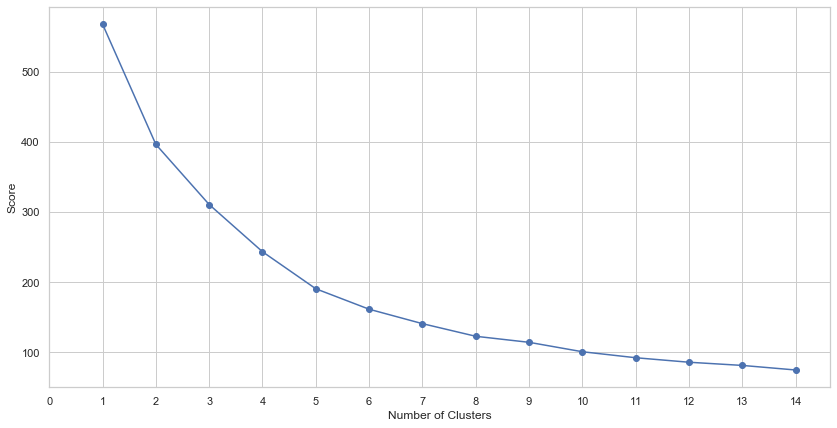

In [226]:
## how many clusters?
plt.figure(figsize= (14, 7))
plt.plot(range(1, 15), scores, marker = 'o')
plt.xticks(np.arange(0, 15, 1))
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

Use 5 clusters in this analysis

In [227]:
## implement 5 clusters on the clustering data
k = 5
kmf = KMeans(n_clusters = k, random_state= 0)
clusters = kmf.fit_predict(toronto_clust)
clusters[:10]

array([0, 0, 0, 3, 0, 0, 3, 4, 0, 0], dtype=int32)

In [228]:
## add clusters to dataframe
df_toronto = toronto_grouped2 ## df_toronto will be used for cluster analysis
## grouped 2 is the data with the latitutde and longitude coordinates

df_toronto['cluster'] = clusters + 1
df_toronto.head()

,neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Yoga Studio,Zoo,Zoo Exhibit,longitude,latitude,shape_area,avg_household_income,population,crime_rate_19,cluster
0,Agincourt North,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,-79.266712,43.805441,1.395145e+07,427037,29113,7.350668,1
1,Agincourt South-Malvern West,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,-79.265612,43.788658,1.511736e+07,278390,23757,13.848550,1
2,Alderwood,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,-79.541611,43.604937,9.502180e+06,168602,12054,7.300481,1
3,Annex,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.01,0.0,0.0,-79.404001,43.671585,5.337192e+06,792507,30526,19.786412,4
4,Banbury-Don Mills,0.0,0.0,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,...,0.00,0.0,0.0,-79.349718,43.737657,1.924897e+07,493486,27695,7.979780,1


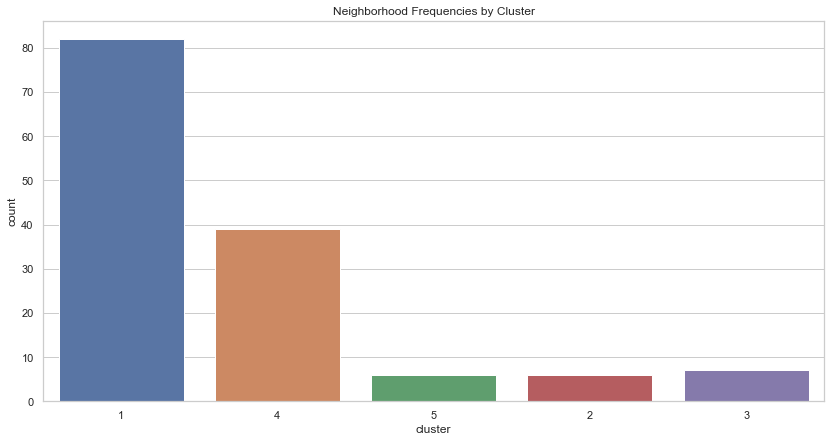

In [229]:
plt.figure(figsize = (14, 7))
sns.countplot(x = 'cluster', data = df_toronto, order = df_toronto['cluster'].unique())
plt.title('Neighborhood Frequencies by Cluster');


In [230]:
## plot number of venues by cluster
## first add cluster variabel to toronto venues data
neighborhood_clust = df_toronto[['neighborhood', 'cluster']]
neighborhood_clust = toronto_venues.merge(neighborhood_clust)
neighborhood_clust.sort_values(by = 'neighborhood', inplace = True)
neighborhood_clust

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category,cluster
434,Agincourt North,43.805441,-79.266712,Chartwell Shopping Centre 集友商場,43.797768,-79.270853,Shopping Mall,1
425,Agincourt North,43.805441,-79.266712,Subway,43.797540,-79.272096,Sandwich Place,1
424,Agincourt North,43.805441,-79.266712,The Beer Store,43.809286,-79.263676,Beer Store,1
423,Agincourt North,43.805441,-79.266712,RBC Royal Bank,43.808757,-79.269280,Bank,1
422,Agincourt North,43.805441,-79.266712,Aromaz Cake and Pastry 龍騰閣,43.797714,-79.270870,Bakery,1
...,...,...,...,...,...,...,...,...
5125,Yorkdale-Glen Park,43.714672,-79.457108,Ardene Shoes Outlet,43.718892,-79.461344,Accessories Store,3
5126,Yorkdale-Glen Park,43.714672,-79.457108,PetSmart,43.716544,-79.445926,Pet Store,3
5127,Yorkdale-Glen Park,43.714672,-79.457108,Dollarama,43.720728,-79.457467,Discount Store,3
5129,Yorkdale-Glen Park,43.714672,-79.457108,Tim Hortons,43.716346,-79.446868,Coffee Shop,3


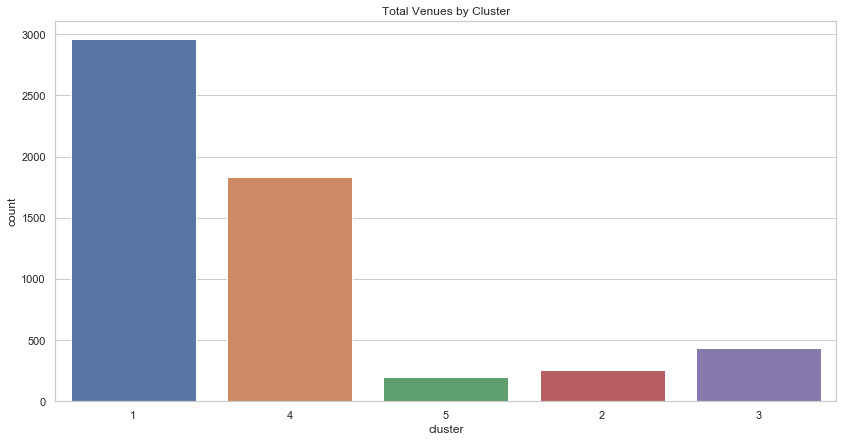

In [231]:
plt.figure(figsize = (14, 7))
sns.countplot(x = 'cluster', data = neighborhood_clust, order = neighborhood_clust['cluster'].unique())
plt.title('Total Venues by Cluster');

### Map of Clusters

In [232]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_toronto = folium.Map(location=[latitude, longitude], zoom_start= 12)

rainbow = ['steelblue', 'crimson', 'purple', 'orange',
          '#00563F']


for lat, lon, area, clust in zip(df_toronto['latitude'], df_toronto['longitude'], df_toronto['neighborhood'], df_toronto['cluster']): 
    folium.CircleMarker(
    [lat, lon],
    popup= area + ' ' + str(clust),
    radius = 4,
    color = rainbow[clust - 1],
    fill = True).add_to(map_toronto)

map_toronto

### Neighborhood Analysis

#### Sort Neighborhoods by Frequent Venues

In [233]:
## function that sorts venues 
def return_most_common_venues(row, n_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:n_venues]

In [234]:
n_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to top venues
columns = ['neighborhood']
for ind in np.arange(n_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['neighborhood'] = toronto_grouped['neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], n_venues)

toronto_venues_sorted['cluster'] = clusters + 1
toronto_venues_sorted.head()


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
0,Agincourt North,Chinese Restaurant,Bakery,Indian Restaurant,Vietnamese Restaurant,Pharmacy,Discount Store,Coffee Shop,Sandwich Place,Bank,Pizza Place,1
1,Agincourt South-Malvern West,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant,Restaurant,Pool Hall,Sushi Restaurant,Breakfast Spot,Sporting Goods Shop,Skating Rink,Shopping Mall,1
2,Alderwood,Gas Station,Convenience Store,Pizza Place,Park,Pharmacy,Donut Shop,Sandwich Place,Moroccan Restaurant,Grocery Store,Gym,1
3,Annex,Italian Restaurant,Coffee Shop,Café,Restaurant,Bakery,Japanese Restaurant,French Restaurant,Grocery Store,Vegetarian / Vegan Restaurant,Mexican Restaurant,4
4,Banbury-Don Mills,Restaurant,Coffee Shop,Café,Women's Store,Japanese Restaurant,Pizza Place,Bank,Pharmacy,Chocolate Shop,New American Restaurant,1


#### Cluster Analysis

In [235]:
## print
def print_clusters(df, clust):
    toronto_clust = df[df['cluster'] == clust]
    return toronto_clust

In [236]:
def print_clust_map(df, color):
    map_toronto = folium.Map(location=[latitude, longitude], zoom_start= 12)

    neighborhoods_clust = df.neighborhood

    clust_df = df_toronto[df_toronto['neighborhood'].isin(neighborhoods_clust)]


    for lat, lon, area, clust in zip(clust_df['latitude'], clust_df['longitude'], clust_df['neighborhood'], clust_df['cluster']): 
        folium.Marker(
        [lat, lon],
        popup= area + ' ' + str(clust),
        icon= folium.Icon(color = color)
        ).add_to(map_toronto)

    return map_toronto

#### Cluster 1

In [237]:
## cluster 1
toronto_1 = print_clusters(toronto_venues_sorted, 1)
print(toronto_1.shape)
toronto_1.head(10)


(82, 12)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
0,Agincourt North,Chinese Restaurant,Bakery,Indian Restaurant,Vietnamese Restaurant,Pharmacy,Discount Store,Coffee Shop,Sandwich Place,Bank,Pizza Place,1
1,Agincourt South-Malvern West,Chinese Restaurant,Cantonese Restaurant,Asian Restaurant,Restaurant,Pool Hall,Sushi Restaurant,Breakfast Spot,Sporting Goods Shop,Skating Rink,Shopping Mall,1
2,Alderwood,Gas Station,Convenience Store,Pizza Place,Park,Pharmacy,Donut Shop,Sandwich Place,Moroccan Restaurant,Grocery Store,Gym,1
4,Banbury-Don Mills,Restaurant,Coffee Shop,Café,Women's Store,Japanese Restaurant,Pizza Place,Bank,Pharmacy,Chocolate Shop,New American Restaurant,1
5,Bathurst Manor,Park,Sports Bar,Playground,Hardware Store,Baseball Field,Men's Store,Breakfast Spot,Grocery Store,Furniture / Home Store,Convenience Store,1
8,Bayview Woods-Steeles,Park,Bank,Gas Station,Recreation Center,Sandwich Place,Coffee Shop,Liquor Store,Japanese Restaurant,Café,Chinese Restaurant,1
9,Bedford Park-Nortown,Pizza Place,Coffee Shop,Italian Restaurant,Bank,Bagel Shop,Hobby Shop,Restaurant,Sandwich Place,Sushi Restaurant,Pharmacy,1
10,Beechborough-Greenbrook,Convenience Store,ATM,Discount Store,Bus Line,Furniture / Home Store,Gas Station,Fast Food Restaurant,Grocery Store,Bar,Sandwich Place,1
11,Bendale,Park,Indian Restaurant,Intersection,Chinese Restaurant,Bakery,Optical Shop,Caribbean Restaurant,Dog Run,Coffee Shop,Grocery Store,1
12,Birchcliffe-Cliffside,Park,Ice Cream Shop,College Stadium,Thai Restaurant,Gym,Gym Pool,Skating Rink,General Entertainment,Restaurant,Diner,1


In [238]:
print_clust_map(toronto_1, 'cadetblue')

#### Cluster 2

In [239]:
## cluster 2
toronto_2 = print_clusters(toronto_venues_sorted, 2)
print(toronto_2.shape)
toronto_2

(6, 12)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
28,Danforth,Coffee Shop,Café,Gastropub,Ethiopian Restaurant,Pizza Place,Park,Sandwich Place,Bar,Burger Joint,Beer Bar,2
70,Leaside-Bennington,Bakery,Indian Restaurant,Burger Joint,Sushi Restaurant,Sporting Goods Shop,Grocery Store,Restaurant,Coffee Shop,Brewery,Construction & Landscaping,2
84,New Toronto,Park,Coffee Shop,Sushi Restaurant,Bakery,Skating Rink,Indian Restaurant,Asian Restaurant,Sandwich Place,Supermarket,Grocery Store,2
126,Weston,Train Station,Pizza Place,Coffee Shop,Diner,Laundromat,Bank,Gas Station,Skating Rink,Thrift / Vintage Store,Jewelry Store,2
127,Weston-Pellam Park,Italian Restaurant,Burger Joint,Café,Mexican Restaurant,Restaurant,Clothing Store,Grocery Store,Bank,Bakery,Coffee Shop,2
134,Woodbine-Lumsden,Grocery Store,Park,Pizza Place,Pharmacy,Coffee Shop,Arts & Crafts Store,Gas Station,Bank,Bar,Beer Store,2


In [240]:
print_clust_map(toronto_2, 'darkred')


#### Cluster 3

In [241]:
## cluster 3
toronto_3 = print_clusters(toronto_venues_sorted, 3)
print(toronto_3.shape)
toronto_3

(7, 12)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
132,Woburn,Coffee Shop,Fast Food Restaurant,Bank,Pharmacy,Discount Store,Indian Restaurant,Park,Big Box Store,Optical Shop,Sandwich Place,3
133,Woodbine Corridor,Indian Restaurant,Café,Park,Grocery Store,Coffee Shop,Bank,Sandwich Place,Bar,Gastropub,Asian Restaurant,3
135,Wychwood,Coffee Shop,Café,Italian Restaurant,Grocery Store,Indian Restaurant,Bakery,Burger Joint,Mexican Restaurant,Restaurant,Pizza Place,3
136,Yonge-Eglinton,Coffee Shop,Italian Restaurant,Sushi Restaurant,Café,Bakery,Japanese Restaurant,Fast Food Restaurant,Restaurant,Pizza Place,Gym,3
137,Yonge-St.Clair,Coffee Shop,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Park,Gym,Grocery Store,Pub,Restaurant,Bank,3
138,York University Heights,Pizza Place,Furniture / Home Store,Coffee Shop,Sports Bar,Shopping Mall,Grocery Store,Bank,Sandwich Place,Office,Chinese Restaurant,3
139,Yorkdale-Glen Park,Fast Food Restaurant,Restaurant,Grocery Store,Coffee Shop,Dessert Shop,Discount Store,Gas Station,Fried Chicken Joint,Furniture / Home Store,Boutique,3


In [242]:
print_clust_map(toronto_3, 'darkpurple')

#### Cluster 4

In [243]:
## cluster 4
toronto_4 = print_clusters(toronto_venues_sorted, 4)
print(toronto_4.shape)
toronto_4.head()

(39, 12)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
3,Annex,Italian Restaurant,Coffee Shop,Café,Restaurant,Bakery,Japanese Restaurant,French Restaurant,Grocery Store,Vegetarian / Vegan Restaurant,Mexican Restaurant,4
6,Bay Street Corridor,Coffee Shop,Café,Clothing Store,Sushi Restaurant,Park,Plaza,Middle Eastern Restaurant,Ramen Restaurant,Cosmetics Shop,Department Store,4
14,Blake-Jones,Café,Coffee Shop,Greek Restaurant,Fast Food Restaurant,Pizza Place,Beer Bar,Sandwich Place,Caribbean Restaurant,Bookstore,Ethiopian Restaurant,4
16,Bridle Path-Sunnybrook-York Mills,Café,Restaurant,Bookstore,Coffee Shop,Trail,College Gym,College Quad,Gym / Fitness Center,Bus Line,Fish Market,4
21,Casa Loma,Coffee Shop,Sandwich Place,Café,Park,Mexican Restaurant,Liquor Store,Pizza Place,Bank,Grocery Store,Ice Cream Shop,4


In [244]:
print_clust_map(toronto_4, 'orange')

#### Cluster 5

In [245]:
## cluster 5
toronto_5 = print_clusters(toronto_venues_sorted, 5)
toronto_5

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
7,Bayview Village,Park,Sporting Goods Shop,Outdoor Supply Store,Fish Market,Metro Station,Breakfast Spot,Fast Food Restaurant,Gas Station,Liquor Store,Shoe Store,5
39,Englemount-Lawrence,Coffee Shop,Fast Food Restaurant,Flower Shop,Gas Station,Sushi Restaurant,Electronics Store,Supermarket,Sandwich Place,Bank,Bakery,5
43,Forest Hill North,Bank,Pizza Place,Coffee Shop,Trail,Middle Eastern Restaurant,Café,Frozen Yogurt Shop,Garden,Skating Rink,Gastropub,5
54,Humber Summit,Gym / Fitness Center,Arts & Crafts Store,Latin American Restaurant,Skating Rink,Pizza Place,General Entertainment,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,5
79,Moss Park,Coffee Shop,Café,Restaurant,Gastropub,Theater,Farmers Market,Italian Restaurant,Diner,Bakery,Food Truck,5
80,Mount Dennis,Furniture / Home Store,Coffee Shop,Pizza Place,Hockey Arena,Golf Course,Fast Food Restaurant,Tennis Court,Bus Line,Ice Cream Shop,Convenience Store,5


In [246]:
print_clust_map(toronto_5, 'darkgreen')

### Restaurant Search

In [247]:
## get list of ethnic restaurant venue categories
restaurants = toronto_venues[toronto_venues['venue_category'].str.contains('Restaurant')]
restaurants = sorted(list(restaurants['venue_category'].unique()))
restaurants.remove('Restaurant')
restaurants.remove('Fast Food Restaurant')
restaurants

['Afghan Restaurant',
 'African Restaurant',
 'American Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Belgian Restaurant',
 'Brazilian Restaurant',
 'Cajun / Creole Restaurant',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Chinese Restaurant',
 'Comfort Food Restaurant',
 'Cuban Restaurant',
 'Dim Sum Restaurant',
 'Doner Restaurant',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Egyptian Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Filipino Restaurant',
 'French Restaurant',
 'German Restaurant',
 'Greek Restaurant',
 'Hawaiian Restaurant',
 'Hong Kong Restaurant',
 'Hotpot Restaurant',
 'Hungarian Restaurant',
 'Indian Chinese Restaurant',
 'Indian Restaurant',
 'Indonesian Restaurant',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Jewish Restaurant',
 'Korean Restaurant',
 'Latin American Restaurant',
 'Malay Restaurant',
 'Mediterranean Restaurant',
 'Mexican Restaurant',
 'Middle Eastern Restaurant',
 'Modern European Restau

In [248]:
## gather all ethnic restaurants from venues dataset
toronto_restaurants = neighborhood_clust[neighborhood_clust['venue_category'].isin(restaurants)]
#toronto_restaurants = toronto_restaurants.merge(toronto_venues_sorted.loc[:,['neighborhood', 'cluster']], left_on = 'neighborhood', right_on = 'neighborhood')
toronto_restaurants.head()

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category,cluster
416,Agincourt North,43.805441,-79.266712,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant,1
414,Agincourt North,43.805441,-79.266712,Grandeur Palace 華丽宮 (Grandeur Palace 華麗宮),43.797885,-79.270585,Chinese Restaurant,1
411,Agincourt North,43.805441,-79.266712,Samosa King - Embassy Restaurant,43.810152,-79.257316,Indian Restaurant,1
410,Agincourt North,43.805441,-79.266712,Saravanaa Bhavan South Indian Restaurant,43.810117,-79.269275,Indian Restaurant,1
428,Agincourt North,43.805441,-79.266712,Xe Lua Vietnamese Cuisine 火車頭,43.809224,-79.269547,Vietnamese Restaurant,1


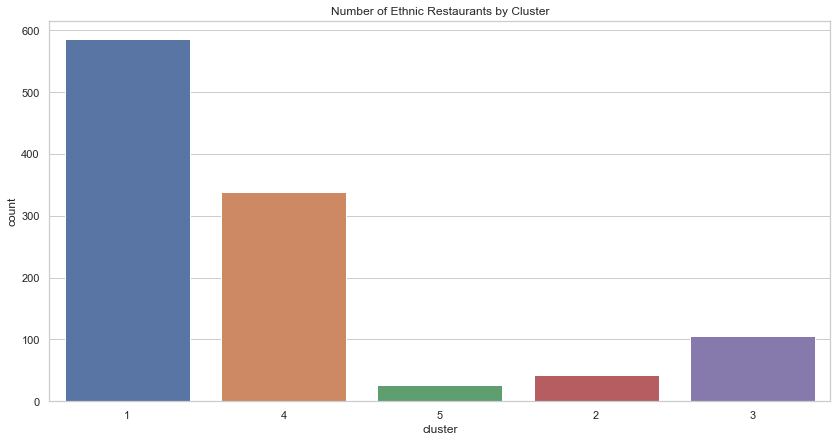

In [249]:
## plot number of ethnic restaurants by cluster
plt.figure(figsize= (14, 7))
sns.countplot(x = 'cluster', data = toronto_restaurants, order = toronto_restaurants['cluster'].unique())
plt.title('Number of Ethnic Restaurants by Cluster');

In [250]:
pd.DataFrame(toronto_restaurants['venue_category'].value_counts()).iloc[:25,:]

,venue_category
Italian Restaurant,127
Sushi Restaurant,73
Indian Restaurant,72
Japanese Restaurant,70
Thai Restaurant,62
Chinese Restaurant,59
Mexican Restaurant,59
Vietnamese Restaurant,51
Middle Eastern Restaurant,48
Greek Restaurant,44


In [303]:
## possible labels for Colombian Restaurant
lat_am_categories = ['Latin American Restaurant', 'South American Restaurant']

## latin american restaurants
lat_am_res = toronto_restaurants[toronto_restaurants['venue_category'].isin(lat_am_categories)]
lat_am_res


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category,cluster
3059,Agincourt South-Malvern West,43.788658,-79.265612,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant,1
4653,Annex,43.671585,-79.404001,Gordo Ex,43.671763,-79.413845,Latin American Restaurant,4
1408,Casa Loma,43.681852,-79.408007,Gourmet Gringos,43.680511,-79.417336,Latin American Restaurant,4
5152,Humber Summit,43.758920,-79.556175,Plaza Latina,43.751294,-79.551793,Latin American Restaurant,5
4796,Humbermede,43.743430,-79.542367,Mi Pueblo,43.739467,-79.538898,Latin American Restaurant,1
2651,Long Branch,43.592362,-79.533345,Empanada Company,43.592213,-79.541679,South American Restaurant,1
2954,Palmerston-Little Italy,43.659157,-79.418409,La Bella Managua Restaurant,43.662162,-79.424929,South American Restaurant,1
1553,Wychwood,43.676919,-79.425515,Mi Tierra,43.680618,-79.431175,South American Restaurant,3
1639,Wychwood,43.676919,-79.425515,Latin Fiesta Restaurant,43.679305,-79.437387,Latin American Restaurant,3
1609,Wychwood,43.676919,-79.425515,Gourmet Gringos,43.680511,-79.417336,Latin American Restaurant,3


In [304]:
## map venues that point the restaurants above by cluster
map_toronto = folium.Map(location=[latitude, longitude], zoom_start= 12)

rainbow = ['steelblue', 'crimson', 'purple', 'orange',
          '#00563F']

rainbow2 = ['cadetblue', 'darkred', 'darkpurple', 'orange',
          'darkgreen']

for lat, lon, area, venue, clust in zip(toronto_restaurants['venue_latitude'], 
                                        toronto_restaurants['venue_longitude'], 
                                        toronto_restaurants['neighborhood'], 
                                        toronto_restaurants['venue_category'],
                                        toronto_restaurants['cluster']): 
    folium.CircleMarker(
    [lat, lon],
    popup= area + " " + venue + " " + str(clust),
    radius = 4,
    color = rainbow[clust - 1],
    fill = True).add_to(map_toronto)
    
for lat, lon, area, venue, name, clust in zip(lat_am_res['venue_latitude'], lat_am_res['venue_longitude'], lat_am_res['neighborhood'], lat_am_res['venue_category'], lat_am_res['venue'], lat_am_res['cluster']): 
    folium.Marker(
    [lat, lon],
    popup= area + "\n " + venue + "\n" + name,
    icon= folium.Icon(color = rainbow2[clust - 1])
    ).add_to(map_toronto)

map_toronto

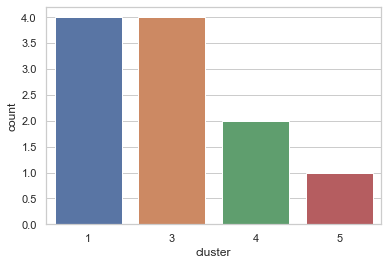

In [253]:
## plot number of restaurants of interest by cluster
lat_ams_clust = toronto_restaurants[toronto_restaurants['venue_category'].isin(lat_am_categories)]
sns.countplot(x = 'cluster', data = lat_ams_clust);

- Latin/South American restaurants are present in either clusters 1, 2, 3, and 5 so it will be better to focus these.

In [254]:
## which neighborhoods feature a Latin American Restaurant in cluster 0

print('Cluster 1\n', toronto_1.isin(lat_am_categories).any())
print('\nCluster 2\n', toronto_2.isin(lat_am_categories).any())
print('\nCluster 3\n', toronto_3.isin(lat_am_categories).any())
print('\nCluster 4\n', toronto_4.isin(lat_am_categories).any())
print('\nCluster 5\n', toronto_5.isin(lat_am_categories).any())


Cluster 1
 neighborhood              False
1st Most Common Venue     False
2nd Most Common Venue     False
3rd Most Common Venue     False
4th Most Common Venue     False
5th Most Common Venue     False
6th Most Common Venue     False
7th Most Common Venue      True
8th Most Common Venue     False
9th Most Common Venue     False
10th Most Common Venue    False
cluster                   False
dtype: bool

Cluster 2
 neighborhood              False
1st Most Common Venue     False
2nd Most Common Venue     False
3rd Most Common Venue     False
4th Most Common Venue     False
5th Most Common Venue     False
6th Most Common Venue     False
7th Most Common Venue     False
8th Most Common Venue     False
9th Most Common Venue     False
10th Most Common Venue    False
cluster                   False
dtype: bool

Cluster 3
 neighborhood              False
1st Most Common Venue     False
2nd Most Common Venue     False
3rd Most Common Venue     False
4th Most Common Venue     False
5th Most Comm

- Latin/South American restaurants are featured in cluster 1 as the 3rd, 5th to 9th most common venues in certain neighborhoods

- Latin/South American restaurants are featured in cluster 5 as the 3rd most common venues in certain neighborhoods

### Map Latin American Restaurants in Clusters 1 and 5

In [255]:
## cluster 1
lat_am1 = toronto_1[toronto_1['7th Most Common Venue'].isin(lat_am_categories)]
lat_am1

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
55,Humbermede,Vietnamese Restaurant,Fast Food Restaurant,Discount Store,Pharmacy,Sandwich Place,Grocery Store,Latin American Restaurant,Nightclub,Coffee Shop,Caribbean Restaurant,1


In [256]:
lat_am5 = toronto_5[toronto_5['3rd Most Common Venue'].isin(lat_am_categories)]
lat_am5

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
54,Humber Summit,Gym / Fitness Center,Arts & Crafts Store,Latin American Restaurant,Skating Rink,Pizza Place,General Entertainment,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,5


- In the map below, all latin american restaurants are marked by a colored dot. The ones with blue markers, on the other hand, are the ones featured in the neighborhood clusters above.

In [257]:
## filter latin american restaurants present in clusters 1 an 5
t_res2 = toronto_restaurants[(toronto_restaurants['cluster'].isin([1, 5])) 
                             & (toronto_restaurants['venue_category'].isin(lat_am_categories))]
t_res2

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category,cluster
3059,Agincourt South-Malvern West,43.788658,-79.265612,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant,1
5152,Humber Summit,43.758920,-79.556175,Plaza Latina,43.751294,-79.551793,Latin American Restaurant,5
4796,Humbermede,43.743430,-79.542367,Mi Pueblo,43.739467,-79.538898,Latin American Restaurant,1
2651,Long Branch,43.592362,-79.533345,Empanada Company,43.592213,-79.541679,South American Restaurant,1
2954,Palmerston-Little Italy,43.659157,-79.418409,La Bella Managua Restaurant,43.662162,-79.424929,South American Restaurant,1


In [258]:
## filter the two neighborhoods identified in clusters 1 and 5
t_res3 = t_res2[t_res2['neighborhood'].isin(['Humbermede', 'Humber Summit'])]
t_res3

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category,cluster
5152,Humber Summit,43.75892,-79.556175,Plaza Latina,43.751294,-79.551793,Latin American Restaurant,5
4796,Humbermede,43.74343,-79.542367,Mi Pueblo,43.739467,-79.538898,Latin American Restaurant,1


In [259]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start= 12)

rainbow2 = ['cadetblue', 'darkred', 'darkpurple', 'orange',
          'darkgreen']

for lat, lon, area, categ, name, clust in zip(t_res2['venue_latitude'], t_res2['venue_longitude'], t_res2['neighborhood'], t_res2['venue_category'], t_res2['venue'], t_res2['cluster']):
    folium.CircleMarker(
    [lat, lon],
    popup= area + " " + venue + " " + str(clust),
    radius = 4,
    color = rainbow[clust - 1],
    fill = True).add_to(map_toronto)
    
for lat, lon, area, categ, name, clust in zip(t_res3['venue_latitude'], t_res3['venue_longitude'], t_res3['neighborhood'], t_res3['venue_category'], t_res3['venue'], t_res3['cluster']):
    folium.Marker(
    [lat, lon],
    popup= area + ",\n" + categ + ",\n " + name,
    icon= folium.Icon(color = rainbow2[clust - 1], icon = 'glyphicon glyphicon-cutlery')
    ).add_to(map_toronto)
    

map_toronto

#### Looking at Neighborhoods where Spanish is Most Spoken

In [260]:
len(spanish_neigh)

20

In [261]:
## Neighborhoods where Spanish is the seocond most spoken language after English
spanish_neigh = ['Glenfield-Jane Heights', 'Downsview-Roding-CFB', 'Rockcliffe-Smythe',
                'Humbermede', 'Brookhaven-Amesbury', 'York University Heights', 'Oakwood Village',
                'Weston', 'Dovercourt-Wallace Emerson-Junction', 'Black Creek', 'Rexdale-Kipling',
                'Elms-Old Rexdale',  'Cabbagetown-South St. James Town', ' Church-Yonge Corridor',
                'Annex', 'Casa Loma', 'Yonge-St. Clair', 'Rosedale-Moore Park', ' Yonge-Eglinton',
                'Mount Dennis']

##list ethnic restaurants 
t_res_sp = toronto_restaurants[(toronto_restaurants['neighborhood'].isin(spanish_neigh))]
t_res_sp


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category,cluster
4653,Annex,43.671585,-79.404001,Gordo Ex,43.671763,-79.413845,Latin American Restaurant,4
4652,Annex,43.671585,-79.404001,Fieramosca Cafe,43.669386,-79.397316,Italian Restaurant,4
4651,Annex,43.671585,-79.404001,Sotto Sotto,43.673633,-79.396156,Italian Restaurant,4
4645,Annex,43.671585,-79.404001,Playa Cabana Hacienda,43.677162,-79.398315,Mexican Restaurant,4
4642,Annex,43.671585,-79.404001,Fat Pasha,43.673784,-79.411770,Jewish Restaurant,4
...,...,...,...,...,...,...,...,...
5084,York University Heights,43.765736,-79.488883,Carribean Heat,43.764155,-79.490227,Caribbean Restaurant,3
5104,York University Heights,43.765736,-79.488883,Tin Tin Congee - 天天粥麵,43.773907,-79.492592,Chinese Restaurant,3
5094,York University Heights,43.765736,-79.488883,Falafel Express,43.764187,-79.489121,Falafel Restaurant,3
5087,York University Heights,43.765736,-79.488883,Bamiyan Kabob,43.773769,-79.492741,Middle Eastern Restaurant,3


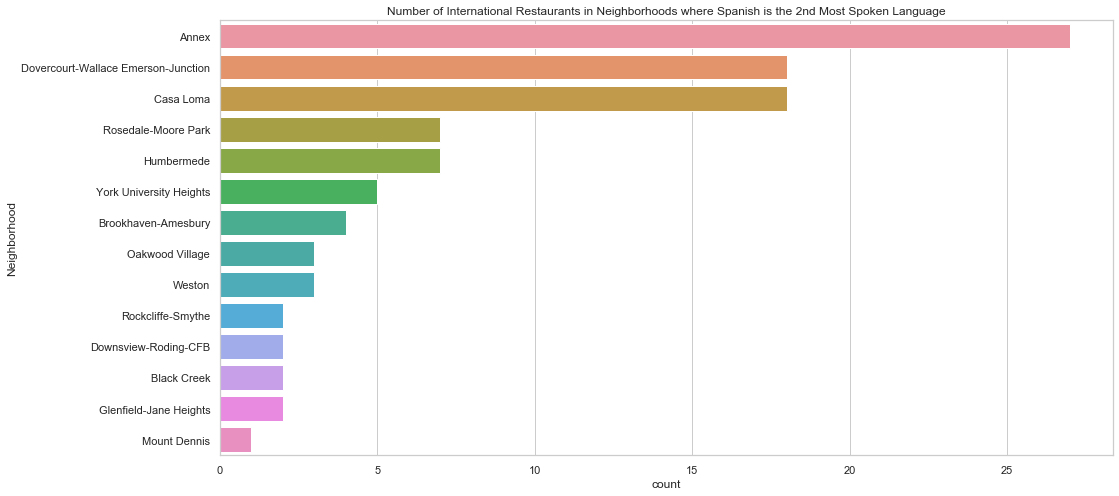

In [262]:
plt.figure(figsize = (16, 8))
sns.countplot(y = 'neighborhood', data = t_res_sp, order = t_res_sp['neighborhood'].value_counts().index)
plt.ylabel('Neighborhood')
plt.title('Number of International Restaurants in Neighborhoods where Spanish is the 2nd Most Spoken Language');

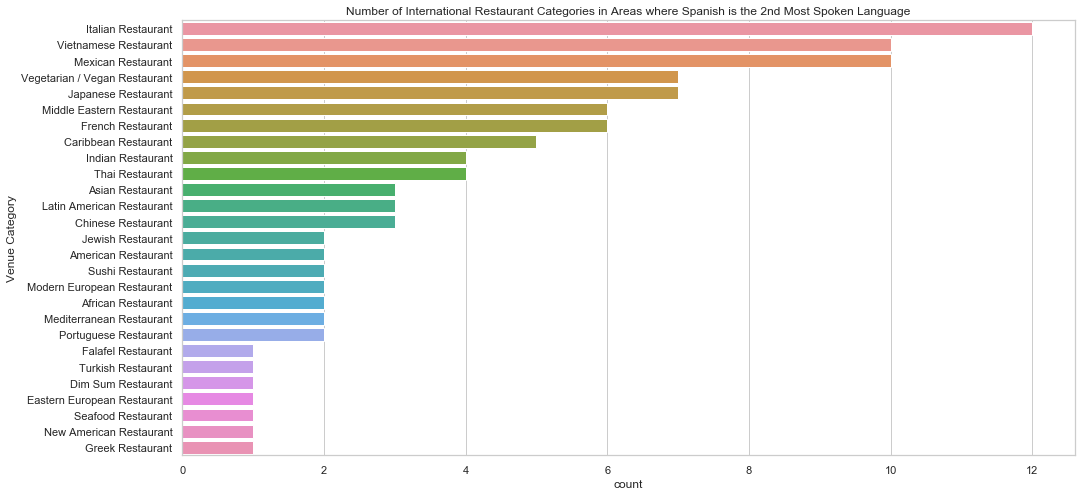

In [263]:
plt.figure(figsize = (16, 8))
sns.countplot(y = 'venue_category', data = t_res_sp, order = t_res_sp['venue_category'].value_counts().index)
plt.ylabel('Venue Category')
plt.title('Number of International Restaurant Categories in Areas where Spanish is the 2nd Most Spoken Language');


In [264]:
toronto_sp = df_toronto[df_toronto['neighborhood'].isin(spanish_neigh)]
toronto_sp.head()


,neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Yoga Studio,Zoo,Zoo Exhibit,longitude,latitude,shape_area,avg_household_income,population,crime_rate_19,cluster
3,Annex,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.010000,0.0,0.0,-79.404001,43.671585,5.337192e+06,792507,30526,19.786412,4
13,Black Creek,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,-79.521979,43.764890,6.627278e+06,261560,21737,16.745641,1
18,Brookhaven-Amesbury,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,-79.485589,43.701326,6.715562e+06,176688,17757,11.938954,1
21,Casa Loma,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.012048,0.0,0.0,-79.408007,43.681852,3.678385e+06,545338,10968,9.117433,4
32,Dovercourt-Wallace Emerson-Junction,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,-79.438541,43.665677,7.125378e+06,594477,36625,15.044369,4


In [265]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start= 12)

rainbow = ['steelblue', 'crimson', 'purple', 'orange',
          '#00563F']


for lat, lon, area, clust in zip(t_res_sp['neighborhood_latitude'], t_res_sp['neighborhood_longitude'], t_res_sp['neighborhood'], t_res_sp['cluster']): 
    folium.Marker(
    [lat, lon],
    popup= area + ' ' + str(clust),
    icon= folium.Icon(color = rainbow2[clust - 1])
    ).add_to(map_toronto)

for lat, lon, area, categ, name, clust in zip(t_res_sp['venue_latitude'], t_res_sp['venue_longitude'], t_res_sp['neighborhood'], t_res_sp['venue_category'], t_res_sp['venue'], t_res_sp['cluster']):
    folium.CircleMarker(
    [lat, lon],
    popup= name + ",\n" + categ + ",\n" + area,
    radius = 4,
    color = rainbow[clust - 1],
    fill = True).add_to(map_toronto)
    

map_toronto

[1] https://www.toronto.com/news-story/5684384-spanish-in-toronto-10-neighbourhoods-where-you-re-likely-to-hear-it/

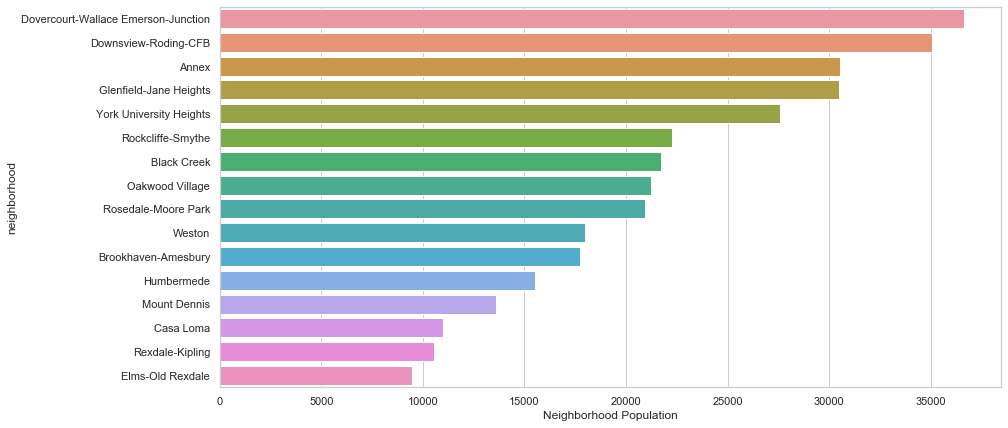

In [266]:
## neighborhoods by population
plt.figure(figsize= (14, 7))
toronto_sp_sorted = toronto_sp.sort_values('population', ascending= False)
sns.barplot(y = 'neighborhood', x = 'population', data = toronto_sp,
           order = toronto_sp_sorted.neighborhood)
plt.xlabel('Neighborhood Population');

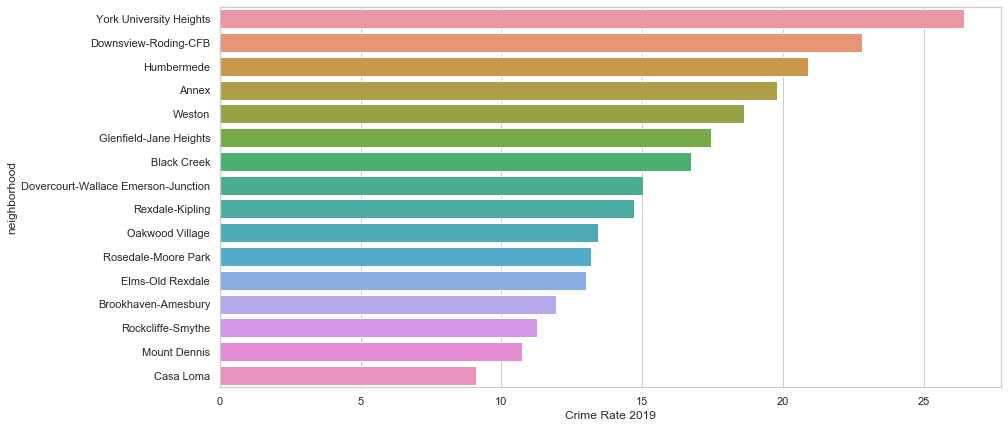

In [267]:
## neighborhoods by crime rate
plt.figure(figsize= (14, 7))
toronto_sp_sorted = toronto_sp.sort_values('crime_rate_19', ascending= False)
sns.barplot(y = 'neighborhood', x = 'crime_rate_19', data = toronto_sp,
           order = toronto_sp_sorted.neighborhood)
plt.xlabel('Crime Rate 2019');

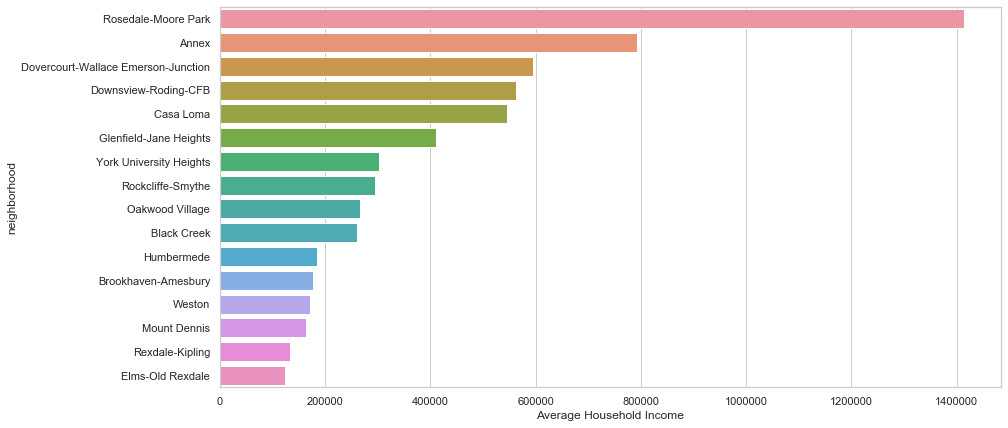

In [268]:
## neighborhoods by houshold income
plt.figure(figsize= (14, 7))
toronto_sp_sorted = toronto_sp.sort_values('avg_household_income', ascending= False)
sns.barplot(y = 'neighborhood', x = 'avg_household_income', data = toronto_sp,
           order = toronto_sp_sorted.neighborhood)
plt.xlabel('Average Household Income');

In [269]:
toronto[toronto['neighborhood'] == 'Elms-Old Rexdale']

,area_code,neighborhood,longitude,latitude,shape_area,avg_household_income,population,crime_rate_19
112,5,Elms-Old Rexdale,-79.548983,43.721519,5.616463e+06,123119,9456,13.007614


- The choices so far:
    - Glenfield-Jane Heights since it has the most Spanish speakers
    - Dovercourt-Wallace Emerson-Junction since it is among the most populated neighborhoods 
    - Humbermede since it is featured in the clusters
    - Casa Loma since it has the lowest crime rate
    - Annex since has the most international cuisine venues

## Results

In [270]:
semifinal_list = ['Glenfield-Jane Heights', 'Dovercourt-Wallace Emerson-Junction',
                  'Humbermede', 'Casa Loma', 'Annex']


In [271]:
toronto_1[toronto_1['neighborhood'].isin(semifinal_list)]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
45,Glenfield-Jane Heights,Vietnamese Restaurant,Tea Room,Coffee Shop,Bank,Grocery Store,Plaza,Moving Target,Food & Drink Shop,Pizza Place,Gym / Fitness Center,1
55,Humbermede,Vietnamese Restaurant,Fast Food Restaurant,Discount Store,Pharmacy,Sandwich Place,Grocery Store,Latin American Restaurant,Nightclub,Coffee Shop,Caribbean Restaurant,1


In [272]:
toronto_2[toronto_2['neighborhood'].isin(semifinal_list)]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster


In [273]:
toronto_3[toronto_3['neighborhood'].isin(semifinal_list)]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster


In [274]:
toronto_4[toronto_4['neighborhood'].isin(semifinal_list)]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
3,Annex,Italian Restaurant,Coffee Shop,Café,Restaurant,Bakery,Japanese Restaurant,French Restaurant,Grocery Store,Vegetarian / Vegan Restaurant,Mexican Restaurant,4
21,Casa Loma,Coffee Shop,Sandwich Place,Café,Park,Mexican Restaurant,Liquor Store,Pizza Place,Bank,Grocery Store,Ice Cream Shop,4
32,Dovercourt-Wallace Emerson-Junction,Bar,Coffee Shop,Bakery,Café,Pharmacy,Park,Mexican Restaurant,Restaurant,Portuguese Restaurant,Italian Restaurant,4


In [275]:
toronto_5[toronto_5['neighborhood'].isin(semifinal_list)]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster


In [280]:
lat_am_res[lat_am_res['neighborhood'].isin(['Dovercourt-Wallace Emerson-Junction','Casa Loma', 'Annex'])]


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category,cluster
4653,Annex,43.671585,-79.404001,Gordo Ex,43.671763,-79.413845,Latin American Restaurant,4
1408,Casa Loma,43.681852,-79.408007,Gourmet Gringos,43.680511,-79.417336,Latin American Restaurant,4


In [298]:
cr_19 =['Neighbourhood', 'Assault_2019', 'AutoTheft_2019', 'BreakandEnter_2019', 'Homicide_2019', 'Robbery_2019', 'TheftOver_2019']
finale_neighs = toronto_cr[toronto_cr['Neighbourhood'].isin(['Casa Loma', 'Annex'])]
final_crime = finale_neighs[cr_19].melt(id_vars = ['Neighbourhood'], var_name = 'crime', value_name = 'crime_rate')
final_crime['crime'] = final_crime.crime.str.replace('_2019', '')
final_crime


,Neighbourhood,crime,crime_rate
0,Casa Loma,Assault,50
1,Annex,Assault,288
2,Casa Loma,AutoTheft,6
3,Annex,AutoTheft,30
4,Casa Loma,BreakandEnter,34
5,Annex,BreakandEnter,212
6,Casa Loma,Homicide,0
7,Annex,Homicide,1
8,Casa Loma,Robbery,8
9,Annex,Robbery,31


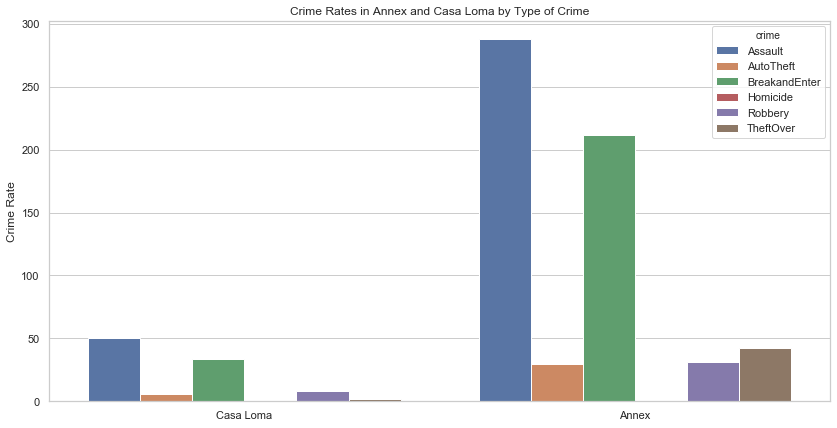

In [301]:
plt.figure(figsize= (14, 7))
sns.barplot(x = 'Neighbourhood', y = 'crime_rate', hue = 'crime', data = final_crime)
plt.ylabel('Crime Rate')
plt.xlabel('')
plt.title('Crime Rates in Annex and Casa Loma by Type of Crime');

In [309]:
casa_loma= toronto_restaurants[(toronto_restaurants['neighborhood'] == 'Casa Loma')]
casa_loma

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category,cluster
1385,Casa Loma,43.681852,-79.408007,Taste of Thai House,43.682735,-79.419661,Thai Restaurant,4
1386,Casa Loma,43.681852,-79.408007,Eastern Twist,43.683092,-79.418501,Indian Restaurant,4
1392,Casa Loma,43.681852,-79.408007,Pizza Banfi,43.688064,-79.414547,Italian Restaurant,4
1348,Casa Loma,43.681852,-79.408007,Scaramouche,43.681293,-79.399492,French Restaurant,4
1352,Casa Loma,43.681852,-79.408007,Playa Cabana,43.676112,-79.401279,Mexican Restaurant,4
1426,Casa Loma,43.681852,-79.408007,La Libre,43.677408,-79.398231,Mexican Restaurant,4
1423,Casa Loma,43.681852,-79.408007,Edo-Ko Japanese Restaurant,43.688078,-79.414541,Japanese Restaurant,4
1422,Casa Loma,43.681852,-79.408007,Sushi Lovers,43.688044,-79.414530,Sushi Restaurant,4
1408,Casa Loma,43.681852,-79.408007,Gourmet Gringos,43.680511,-79.417336,Latin American Restaurant,4
1415,Casa Loma,43.681852,-79.408007,Freshii,43.689047,-79.412819,Vegetarian / Vegan Restaurant,4


In [308]:
casa_loma.venue_category.value_counts()

Mexican Restaurant               3
French Restaurant                2
Indian Restaurant                2
Vegetarian / Vegan Restaurant    2
Middle Eastern Restaurant        2
Thai Restaurant                  1
Italian Restaurant               1
Latin American Restaurant        1
Jewish Restaurant                1
Japanese Restaurant              1
Sushi Restaurant                 1
Modern European Restaurant       1
Name: venue_category, dtype: int64